In [1]:
import sys
sys.executable

'/home/ec2-user/anaconda/envs/veliadash/bin/python'

In [5]:
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import json

In [1]:
vtx_id_to_transcripts

NameError: name 'vtx_id_to_transcripts' is not defined

In [6]:
def load_xena_tcga_gtex_target():
    xena_metadata = pd.read_table('./data/TcgaTargetGTEX_phenotype.txt', encoding='latin-1', index_col=0)
    xena_expression = pd.read_feather('./data/xena_ucsc_phase1to6.feather')
    xena_expression.index = xena_expression.pop('index')
    xena_metadata = xena_metadata.loc[xena_expression.index]
    vtx_id_to_transcripts = json.load(open('./data/vtx_to_ensembl_ids.json', 'r'))
    return xena_metadata, xena_expression, vtx_id_to_transcripts
xena_metadata, xena_expression, vtx_id_to_transcripts = load_xena_tcga_gtex_target()

In [104]:
def load_tcga_tumor_vs_nat(xena_metadata, xena_expression):
    cancers = pd.read_csv('./data/cancer_types.txt', header=None, names = ['Disease', 'Code'])
    cancers.index = [i.lower() for i in cancers['Disease']]
    tcga_paired_normal = {}
    tcga_paired_normal_index = []
    pairs = pd.read_excel('./data/tissue_pairs.xlsx')
    for ix, row in pairs.iterrows():
        if isinstance(row['NAT (Solid Tissue Normal)'], str):
            tcga_groups = xena_metadata[(xena_metadata['_primary_site'] == row['Tissue (Disease)']) & (xena_metadata['_study'] == 'TCGA')].copy()
            for cancer in tcga_groups['primary disease or tissue'].unique():
                primary_tumor_samples = tcga_groups[(tcga_groups['primary disease or tissue']==cancer) & 
                                                   (tcga_groups['_sample_type']=='Primary Tumor')].index
                normal_adjacent_samples = tcga_groups[(tcga_groups['primary disease or tissue']==cancer) & 
                                                   (tcga_groups['_sample_type']=='Solid Tissue Normal')].index
                if len(primary_tumor_samples)>=8 and (len(normal_adjacent_samples)>=8):
                    tcga_paired_normal[cancer] = {'Tumor': primary_tumor_samples, 'NAT': normal_adjacent_samples}
                    tcga_paired_normal_index += list(primary_tumor_samples)+list(normal_adjacent_samples)
        else:
            continue
    tcga_nat_table = xena_expression.loc[tcga_paired_normal_index].copy()
    tcga_nat_table.insert(0, 'Cancer', '')
    tcga_nat_table.insert(1, 'Condition', '')
    for c, s in tcga_paired_normal.items():
        tcga_nat_table.loc[s['Tumor'], 'Cancer'] = c
        tcga_nat_table.loc[s['NAT'], 'Cancer'] = c
        tcga_nat_table.loc[s['Tumor'], 'Condition'] = 'Cancer'
        tcga_nat_table.loc[s['NAT'], 'Condition'] = 'Normal Adjacent'
    ave_per_transcript_per_cancer = tcga_nat_table.groupby(['Cancer', 'Condition']).mean()
    ave_per_transcript_per_cancer = ave_per_transcript_per_cancer.reset_index()
    stats_per_tumor = {}
    for c, s in tcga_paired_normal.items():
        tumor = tcga_nat_table.loc[s['Tumor'], tcga_nat_table.columns[2:]]
        normal = tcga_nat_table.loc[s['NAT'], tcga_nat_table.columns[2:]]
        logfcs = tumor.mean(axis=0) - normal.mean(axis=0)
        test_statistic, p_value = ranksums(tumor, normal, alternative='two-sided')

        stats = pd.DataFrame({'ranksum': test_statistic, 'p_value': p_value, 'logFC': logfcs.values, 
                 'FDR': multipletests(p_value, method='fdr_bh')[1]}, index=tumor.columns)
        stats_per_tumor[c] = stats.copy()
    logfcs = tumor.mean(axis=0) - normal.mean(axis=0)
    return ave_per_transcript_per_cancer, logfcs, stats_per_tumor
ave_per_transcript_per_cancer, logfcs, stats_per_tumor = load_tcga_tumor_vs_nat(xena_metadata, xena_expression)

In [111]:
transcript_ids = tids

In [114]:
logfcs

-2.8838033326607477

In [118]:
logfcs

-2.8838033326607477

In [119]:
test_statistic

-3.024028244192858

In [ ]:
tumor

In [139]:
normal = tcga_nat_table[tcga_nat_table.Condition=='Normal Adjacent']8
tumor = tcga_nat_table[tcga_nat_table.Condition=='Cancer'].groupby('Cancer')[overlap].mean().sum(axis=1)
logfcs = tumor - normal
test_statistic, p_value = ranksums(tumor, normal, alternative='two-sided')
p_value

0.2086852353761599

In [132]:
    overlap = list(set(transcript_ids).intersection(set(tcga_nat_table.columns[2:])))
    tumor = tcga_nat_table.loc[s['Tumor'], overlap].sum(axis=1)
    normal = tcga_nat_table.loc[s['NAT'], overlap].sum(axis=1)
    logfcs = tumor - normal
    test_statistic, p_value = ranksums(tumor, normal, alternative='two-sided')
    
    # stats = pd.DataFrame({'ranksum': test_statistic, 'p_value': p_value, 'logFC': logfcs.values, 
             # 'FDR': multipletests(p_value, method='fdr_bh')[1]}, index=tumor.columns)

In [ ]:
def estimate_ranksums_per_sorf(tcga_nat_table, transcript_ids):
    overlap = set(transcript_ids).intersection(set(tcga_nat_table.columns[2:]))
    tumor = tcga_nat_table.loc[s['Tumor'], overlap].sum(axis=1)
    normal = tcga_nat_table.loc[s['NAT'], overlap].sum(axis=1)
    logfcs = tumor.mean(axis=0) - normal.mean(axis=0)
    test_statistic, p_value = ranksums(tumor, normal, alternative='two-sided')
    stats = pd.DataFrame({'ranksum': test_statistic, 'p_value': p_value, 'logFC': logfcs.values, 
             'FDR': multipletests(p_value, method='fdr_bh')[1]}, index=tumor.columns)
    

In [109]:
for vtx_id, tids in vtx_id_to_transcripts.items():
    
    break
tids

['ENST00000263741',
 'ENST00000360001',
 'ENST00000459994',
 'ENST00000465727',
 'ENST00000660930']

In [15]:
import jsonlines
def load_esmfold():
    esmfold = {}
    with jsonlines.open('./data/phase1to6_secreted_esmfold.json') as fopen:
        for l in fopen.iter():
            esmfold[l['sequence']] = l
    return esmfold
e = load_esmfold()
# e = {v['id']: v['mean_plddt'] for k, v in e.items()}


784

In [73]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

def plot_plddt_legend(dpi=100):
  thresh = ['plDDT:','Very low (<50)','Low (60)','OK (70)','Confident (80)','Very high (>90)']
  plt.figure(figsize=(1,0.1),dpi=dpi)
  ########################################
  for c in ["#FFFFFF","#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt


def show_pdb(pdb, rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(pdb ,'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

In [ ]:
py3Dmol.view(

In [30]:
import pandas as pd
from st_aggrid import AgGrid
import json
import numpy as np

df = pd.read_excel('./data/interim_phase1to6_secreted_hits_20230330.xlsx')

In [71]:
import plotly.express as px
px.plotly

In [69]:
import jsonlines
esmfold = {}
with jsonlines.open('./data/phase1to6_secreted_esmfold.json') as fopen:
    for l in fopen.iter():
        esmfold[l['sequence']] = l


In [36]:
np.percentile(e['IAFTVFFRLLRTWHLQMAPVHVLCCVSVLLATFYLTPTESAGSLVSYTPNSCCYGFQQHPPPVQILKEWYPTSPACPKPGVILLTKRGRQICADPSKNWVRQLMQRLPAIA']['plddt'], 90)

83.3119888305664

In [18]:
    xena_metadata = pd.read_table('./data/TcgaTargetGTEX_phenotype.txt', encoding='latin-1', index_col=0)
    xena_expression = pd.read_feather('./data/xena_ucsc_phase1to6.feather')
    xena_expression.index = xena_expression.pop('index')
    xena_metadata = xena_metadata.loc[xena_expression.index]
    vtx_id_to_transcripts = json.load(open('./data/vtx_to_ensembl_ids.json', 'r'))

In [31]:
xena_metadata.columns

Index(['detailed_category', 'primary disease or tissue', '_primary_site',
       '_sample_type', '_gender', '_study'],
      dtype='object')

In [22]:
sorf_excel_table = pd.read_excel('./data/interim_phase1to6_secreted_hits_20230330.xlsx')

In [20]:
st.session_state['id_type_selected'] = 'primary_id'

2023-04-07 19:33:13.526 Session state does not function when running a script without `streamlit run`


In [ ]:
sorf_excel_table[st.session_state['id_type_selected']]

In [24]:
sorf_excel_table.head(3)

,vtx_id,primary_id,genscript_id,phase,orf_xref,protein_xrefs,gene_xref,transcript_xref,source,sec_trans_ratio,...,chromosome,strand,start,end,chrom_starts,block_sizes,phases,nucl,aa,isoform_of
0,VTX-0850284,smORF32119,U8990HF130-8,Phase 1,smORF32119;U8990HF130-8,smORF32119;6xhis-HSA-HRV3C-smORF32119_02;VTXRP011,ENSG00000078808.20;HGNC:24188;SDF4;24188;51150...,CHS.68.20;CHS.68.7;CHS.68.8;ENST00000360001.12...,velia_phase1_secreted_smORFs,1.459455,...,chr1,-,1228464,1228739,1228464,275,0,GCTCCGTGCTGCCTCTGGCTCCTGGGGGCAGTCCTTCTGATGGACG...,APCCLWLLGAVLLMDASARPANHSSTRERVANREENEILPPDHLNG...,"['ENSP00000435962.1', 'ENSP00000263741.8', 'EN..."
1,VTX-0850613,smORF85917,U6813HF130-147,Phase 1,smORF85917;U6813HF130-147,smORF85917,220323;28752;ENSG00000184232.9;gene-OAF;HGNC:2...,CHS.10211.2;ENST00000328965.9;NM_178507.4;OTTH...,velia_phase1_secreted_smORFs,1.682371,...,chr11,+,120211301,120211552,120211301,251,0,CTGGCGCGCCCTGCGCTGCTGCTGCTGCTGCCGCTGCTCGCGCCGC...,LARPALLLLLPLLAPLLGTGAPAELRVRVRLPDGQVTEESLQADSD...,NaN
2,VTX-0850424,smORF419458,U8990HF130-150,Phase 1,smORF419458;U8990HF130-150,smORF419458;6xhis-HSA-HRV3C-smORF419458_02;VTX...,ENSG00000164106.8;HGNC:17036;SCRG1;11341;17036...,CHS.41825.2;ENST00000296506.8;NM_007281.4;OTTH...,velia_phase1_secreted_smORFs,1.265618,...,chr4,-,173391169,173391408,173391169,239,0,CTGATGGTACTTGTTTTCACCATTGGGCTAACTTTGCTGCTAGGAG...,LMVLVFTIGLTLLLGVQAMPANRLSCYRKILKDHNCHNLPEGVADL...,"['ENSP00000425404.1', 'ENSP00000296506.2']"


In [37]:
vtx_id = 'VTX-0850284'

In [38]:
selected_transcripts = vtx_id_to_transcripts[vtx_id]

In [39]:
selected_expression = xena_expression[xena_expression.columns.intersection(selected_transcripts)]

In [54]:
groups = list(map(lambda x: '-'.join(map(str, x)), xena_metadata[['_primary_site', '_study']].values))
selected_expression.groupby(groups).mean()

,ENST00000263741,ENST00000360001,ENST00000459994,ENST00000465727
Adipose Tissue-GTEX,1.662754,6.226025,-5.880810,-4.577644
Adrenal Gland-GTEX,1.766799,6.046630,-5.936627,-5.232531
Adrenal gland-TCGA,0.684144,6.049535,-4.437922,-6.234008
Bile duct-TCGA,1.317004,6.166382,-2.364967,-7.717398
Bladder-GTEX,1.814756,6.382389,-6.420600,-2.769567
...,...,...,...,...
Vagina-GTEX,1.380554,5.945636,-5.498920,-4.946567
White blood cell-TARGET,-0.638910,4.211006,-9.329959,-5.397660
White blood cell-TCGA,0.458168,5.391580,-9.864399,-6.488747
nan-GTEX,1.138000,5.797675,-7.439650,-5.186875


In [29]:
vtx_id = sorf_excel_table[sorf_excel_table['primary_id'] == 'smORF32119']
vtx_id.iloc[0]['vtx_id']

'VTX-0850284'

In [37]:
ag_df.columns

NameError: name 'ag_df' is not defined

In [42]:

xena_metadata = pd.read_table('./data/TcgaTargetGTEX_phenotype.txt', encoding='latin-1', index_col=0)

In [45]:
xena_expression = pd.read_feather('./data/xena_ucsc_phase1to6.feather')
xena_expression.index = xena_expression.pop('index')

In [ ]:
def load_tcga_tumor_vs_nat(xena_metadata, xena_expression):
    cancers = pd.read_csv('./data/cancer_types.txt', header=None, names = ['Disease', 'Code'])
    cancers.index = [i.lower() for i in cancers['Disease']]
    tcga_paired_normal = {}
    tcga_paired_normal_index = []
    pairs = pd.read_excel('./data/tissue_pairs.xlsx')
    for ix, row in pairs.iterrows():
        if isinstance(row['NAT (Solid Tissue Normal)'], str):
            tcga_groups = xena_metadata[(xena_metadata['_primary_site'] == row['Tissue (Disease)']) & (xena_metadata['_study'] == 'TCGA')].copy()
            for cancer in tcga_groups['primary disease or tissue'].unique():
                primary_tumor_samples = tcga_groups[(tcga_groups['primary disease or tissue']==cancer) & 
                                                   (tcga_groups['_sample_type']=='Primary Tumor')].index
                normal_adjacent_samples = tcga_groups[(tcga_groups['primary disease or tissue']==cancer) & 
                                                   (tcga_groups['_sample_type']=='Solid Tissue Normal')].index
                if len(primary_tumor_samples)>=8 and (len(normal_adjacent_samples)>=8):
                    tcga_paired_normal[cancer] = {'Tumor': primary_tumor_samples, 'NAT': normal_adjacent_samples}
                    tcga_paired_normal_index += list(primary_tumor_samples)+list(normal_adjacent_samples)
        else:
            continue
    tcga_nat_table = xena_expression.loc[tcga_paired_normal_index].copy()
    tcga_nat_table.insert(0, 'Cancer', '')
    tcga_nat_table.insert(1, 'Condition', '')
    for c, s in tcga_paired_normal.items():
        tcga_nat_table.loc[s['Tumor'], 'Cancer'] = c
        tcga_nat_table.loc[s['NAT'], 'Cancer'] = c
        tcga_nat_table.loc[s['Tumor'], 'Condition'] = 'Cancer'
        tcga_nat_table.loc[s['NAT'], 'Condition'] = 'Normal Adjacent'
    ave_per_transcript_per_cancer = tcga_nat_table.groupby(['Cancer', 'Condition']).mean()
    ave_per_transcript_per_cancer = ave_per_transcript_per_cancer.reset_index()
    stats_per_tumor = {}
    for c, s in tqdm(tcga_paired_normal.items()):
        tumor = tcga_nat_table.loc[s['Tumor'], tcga_nat_table.columns[2:]]
        normal = tcga_nat_table.loc[s['NAT'], tcga_nat_table.columns[2:]]
        logfcs = tumor.mean(axis=0) - normal.mean(axis=0)
        test_statistic, p_value = ranksums(tumor, normal, alternative='two-sided')

        stats = pd.DataFrame({'ranksum': test_statistic, 'p_value': p_value, 'logFC': logfcs.values, 
                 'FDR': multipletests(p_value, method='fdr_bh')[1]}, index=tumor.columns)
        stats_per_tumor[c] = stats.copy()
    logfcs = tumor.mean(axis=0) - normal.mean(axis=0)
    return ave_per_transcript_per_cancer

In [48]:
tcga_paired_normal = {}
tcga_paired_normal_index = []
pairs = pd.read_excel('./data/tissue_pairs.xlsx')
for ix, row in pairs.iterrows():
    if isinstance(row['NAT (Solid Tissue Normal)'], str):
        tcga_groups = xena_metadata[(xena_metadata['_primary_site'] == row['Tissue (Disease)']) & (xena_metadata['_study'] == 'TCGA')].copy()
        for cancer in tcga_groups['primary disease or tissue'].unique():
            primary_tumor_samples = tcga_groups[(tcga_groups['primary disease or tissue']==cancer) & 
                                               (tcga_groups['_sample_type']=='Primary Tumor')].index
            normal_adjacent_samples = tcga_groups[(tcga_groups['primary disease or tissue']==cancer) & 
                                               (tcga_groups['_sample_type']=='Solid Tissue Normal')].index
            if len(primary_tumor_samples)>=8 and (len(normal_adjacent_samples)>=8):
                tcga_paired_normal[cancer] = {'Tumor': primary_tumor_samples, 'NAT': normal_adjacent_samples}
                tcga_paired_normal_index += list(primary_tumor_samples)+list(normal_adjacent_samples)
    else:
        continue
tcga_nat_table = xena_expression.loc[tcga_paired_normal_index].copy()
tcga_nat_table.insert(0, 'Cancer', '')
tcga_nat_table.insert(1, 'Condition', '')
for c, s in tcga_paired_normal.items():
    tcga_nat_table.loc[s['Tumor'], 'Cancer'] = c
    tcga_nat_table.loc[s['NAT'], 'Cancer'] = c
    tcga_nat_table.loc[s['Tumor'], 'Condition'] = 'Cancer'
    tcga_nat_table.loc[s['NAT'], 'Condition'] = 'Normal Adjacent'
ave_per_transcript_per_cancer = tcga_nat_table.groupby(['Cancer', 'Condition']).mean()
ave_per_transcript_per_cancer = ave_per_transcript_per_cancer.reset_index()

In [55]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


In [102]:
base_link = "http://genome.ucsc.edu/cgi-bin/hgTracks?"
genome = "db=hg38"
chrom = 'chr15'
start = 64162657
end = 64162944
position = f"{chrom}:{start}-{end}"
ucsc_link = f"{base_link}{genome}&position={position}"
ucsc_link

'http://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&position=chr15:64162657-64162944'

In [60]:
ave_per_transcript_per_cancer.head(2)

,Cancer,Condition,ENST00000046640,ENST00000064724,ENST00000075322,ENST00000084795,ENST00000175756,ENST00000181796,ENST00000217121,ENST00000217428,...,ENST00000630242,ENST00000630243,ENST00000630417,ENST00000630482,ENST00000630717,ENST00000630863,ENST00000630874,ENST00000631105,ENST00000631189,ENST00000631366
0,Bladder Urothelial Carcinoma,Cancer,2.292933,-0.673245,-6.154497,10.058762,3.934293,-9.747943,-7.480388,-8.799299,...,-5.787936,-7.865831,-6.052789,-9.111968,-9.69137,-9.588936,-8.823113,-9.623387,-9.411501,-7.611047
1,Bladder Urothelial Carcinoma,Normal Adjacent,1.988821,2.076905,-2.803753,9.745568,3.644284,-9.965800,-9.253105,-7.373000,...,-4.918753,-6.807900,-7.600558,-9.965800,-9.96580,-8.616100,-8.508921,-8.703642,-9.579963,-8.699458


In [64]:
import altair as alt

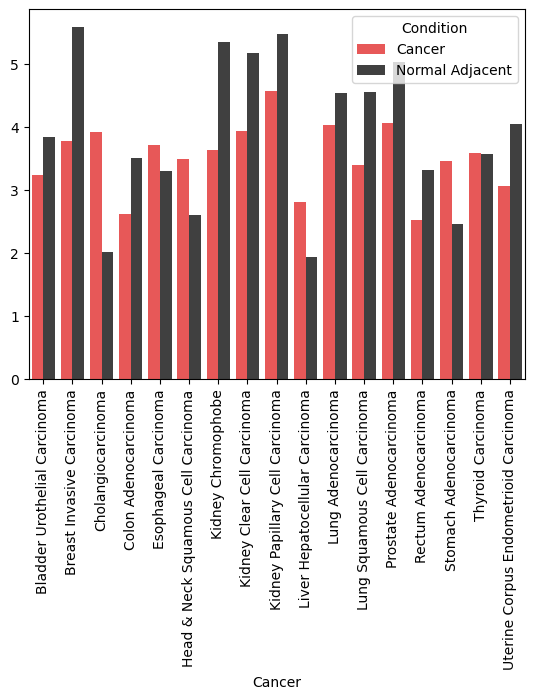

In [98]:
selected_transcripts = ['ENST00000046640', 'ENST00000064724']
exp_bplot = sns.barplot(data = ave_per_transcript_per_cancer, x='Cancer',
            y=ave_per_transcript_per_cancer[selected_transcripts].apply(lambda x: np.log2(np.sum(np.exp(x)-1)+1), axis=1),
            hue='Condition', alpha=0.75, palette=["r", "k"])
exp_bplot.set_xticks(exp_bplot.get_xticks(), exp_bplot.get_xticklabels(), rotation=90)

In [162]:
selected_expression

,ENST00000263741,ENST00000360001,ENST00000459994,ENST00000465727
index,,,,
GTEX-S4Q7-0003-SM-3NM8M,0.7146,5.3924,0.1903,-1.2142
TCGA-19-1787-01,2.3620,6.9667,-1.1172,-0.4921
TCGA-S9-A7J2-01,0.0990,5.3948,1.7489,-9.9658
GTEX-QV31-1626-SM-2S1QC,1.7446,6.4748,2.6278,-0.9971
TCGA-G3-A3CH-11,0.8726,5.8836,-1.8836,-9.9658
...,...,...,...,...
GTEX-11ZTS-3326-SM-5LU9Y,2.6019,6.2493,-9.9658,-0.6643
TCGA-DD-A115-01,1.9527,7.0944,2.8280,-9.9658
GTEX-ZA64-2126-SM-5Q5A8,2.5756,6.3036,-0.0725,-9.9658


In [173]:
selected_expression.min()

ENST00000263741   -9.9658
ENST00000360001   -9.9658
ENST00000459994   -9.9658
ENST00000465727   -9.9658
dtype: float64

In [183]:
        xena_expression.apply(lambda x: np.exp2(x).round(3)-0.001).min()

ENST00000046640    0.0
ENST00000064724    0.0
ENST00000075322    0.0
ENST00000084795    0.0
ENST00000175756    0.0
                  ... 
ENST00000630863    0.0
ENST00000630874    0.0
ENST00000631105    0.0
ENST00000631189    0.0
ENST00000631366    0.0
Length: 2020, dtype: float64

In [198]:
expression_table = {}
xena_metadata = xena_metadata.loc[xena_metadata._primary_site.dropna().index].copy()
for vtx_id in tqdm(df['vtx_id']):
    # Plot transcript expression levels
    selected_transcripts = vtx_id_to_transcripts[vtx_id]
    xena_overlap = xena_expression.columns.intersection(selected_transcripts)
    if len(xena_overlap)>=1:
        selected_expression = xena_expression[xena_overlap].copy()
        selected_expression = selected_expression.apply(lambda x: np.exp2(x).round(3)-0.001)
        groups = list(map(lambda x: '-'.join(map(str, x)), xena_metadata[['_study', '_primary_site', '_sample_type']].values))
        e = selected_expression.loc[xena_metadata.index].groupby(groups).mean().sum(axis=1)
        expression_table[vtx_id] = e
    else:
        expression_table[vtx_id] = [np.nan]*len(set(groups))
        # break

100%|██████████| 805/805 [00:43<00:00, 18.69it/s]


In [203]:
pd.DataFrame(expression_table).T.to_excel('sorf_expression_tcga_gtex_target.xlsx')

In [156]:
xena_metadata.loc[~(xena_metadata[['_study', '_primary_site', '_sample_type']].isna())]

ValueError: Cannot index with multidimensional key

In [143]:
groups

['Blood-GTEX',
 'Brain-TCGA',
 'Brain-TCGA',
 'Blood Vessel-GTEX',
 'Liver-TCGA',
 'Uterus-GTEX',
 'Thyroid-GTEX',
 'Blood Vessel-GTEX',
 'Cervix-TCGA',
 'Colon-TCGA',
 'Brain-TCGA',
 'Blood Vessel-GTEX',
 'Lining of body cavities-TCGA',
 'Skin-TCGA',
 'Muscle-GTEX',
 'Lung-GTEX',
 'Skin-GTEX',
 'Lung-TCGA',
 'Muscle-GTEX',
 'Colon-GTEX',
 'Testis-TCGA',
 'Nerve-GTEX',
 'Soft tissue,Bone-TCGA',
 'Kidney-TCGA',
 'Breast-TCGA',
 'Skin-GTEX',
 'Nerve-GTEX',
 'Prostate-TCGA',
 'Stomach-TCGA',
 'Esophagus-TCGA',
 'Skin-TCGA',
 'Kidney-TCGA',
 'White blood cell-TARGET',
 'Brain-GTEX',
 'Blood-GTEX',
 'Kidney-TCGA',
 'Thyroid-GTEX',
 'Brain-TCGA',
 'Soft tissue,Bone-TCGA',
 'Stomach-TCGA',
 'Prostate-TCGA',
 'Breast-TCGA',
 'Lung-GTEX',
 'Head and Neck region-TCGA',
 'Prostate-TCGA',
 'Muscle-GTEX',
 'Cervix-TCGA',
 'Brain-TCGA',
 'Thyroid-GTEX',
 'Kidney-TCGA',
 'Ovary-TCGA',
 'Kidney-TCGA',
 'Prostate-TCGA',
 'Skin-TCGA',
 'Blood Vessel-GTEX',
 'Lung-GTEX',
 'Colon-TCGA',
 'Breast-TCGA',
 '